In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# Random forest modelling
### Note: outliers are included in this script as they don't affect RF models

In [102]:
data = pd.read_csv('england/with_density_no_outliers.csv')

# remove thousands separator (eg. 1,000)
data['population_density'] = data['population_density'].str.replace(',', '').astype('float32')

In [103]:
data.head()

,lsoa11,population_density,year,loneills,lsoa_name,district_code,district_name,imd_score,imd_rank,imd_decile,...,indoor_sub_rank,indoor_sub_decile,outdoor_sub_score,outdoor_sub_rank,outdoor_sub_decile,total_population,aged_under_15_population,aged_16-59_population,aged_over_60_population,working_age_population
0,E01020636,1886.0,2015,0.651901,County Durham 001C,E06000047,County Durham,21.632,12979.0,4.0,...,32265.0,10.0,-1.482,31684.0,10.0,1704.0,306.0,956.0,442.0,976.50
1,E01020629,3270.0,2015,0.299419,County Durham 003C,E06000047,County Durham,19.084,14979.0,5.0,...,25589.0,8.0,-1.215,30432.0,10.0,1488.0,304.0,836.0,348.0,839.25
2,E01020655,242.0,2015,-0.231131,County Durham 003D,E06000047,County Durham,11.477,22411.0,7.0,...,29921.0,10.0,-1.748,32368.0,10.0,2039.0,333.0,1115.0,591.0,1142.50
3,E01020661,2193.0,2015,-1.047568,County Durham 004A,E06000047,County Durham,27.441,9495.0,3.0,...,19737.0,7.0,-0.446,22845.0,7.0,1841.0,316.0,1046.0,479.0,1073.50
4,E01020615,2871.0,2015,-1.014707,County Durham 005B,E06000047,County Durham,39.224,4745.0,2.0,...,32597.0,10.0,-0.440,22773.0,7.0,1786.0,352.0,984.0,450.0,981.00


Perform a trivial train-test split. Cross validation is not needed in RF in theory.

In [109]:
def process_data(dataframe):
    train, test = train_test_split(dataframe, test_size=0.2)
    x_train = train.copy()
    x_test = test.copy()
    for feature in ['lsoa11', 'year', 'lsoa_name', 'district_code', 'district_name', 'loneills']:
        if feature in list(dataframe.columns):
            x_train.drop(feature, axis=1, inplace=True)
            x_test.drop(feature, axis=1, inplace=True)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    y_train = train['loneills']
    y_test = test['loneills']
    return x_train, y_train, x_test, y_test

In [110]:
x_train, y_train, x_test, y_test = process_data(data)

In [111]:
model = RandomForestRegressor()

In [112]:
model.fit(x_train, y_train)

RandomForestRegressor()

In [113]:
model.score(x_test, y_test)

0.0580647076124019

Really poor performance. Should we do hyperparameter tuning? Maybe not worth it.

In [17]:
def feature_imp(model, x_train):
    importance = model.feature_importances_
    features = x_train.columns
    feature_importance = pd.DataFrame({'Feature': features, 'Importance': importance})

    #order them by importance
    feature_importance.sort_values(by=['Importance'], ascending=False, inplace=True)
    print(feature_importance)
    plt.bar(range(len(importance)),importance)
    plt.xticks(range(len(importance)), features, rotation=90)

                      Feature  Importance
35      adult_skills_sub_rank    0.067990
50   aged_under_15_population    0.053270
29            poor_older_rank    0.047967
40   wider_barriers_sub_score    0.046122
0          population_density    0.043331
41    wider_barriers_sub_rank    0.037901
52    aged_over_60_population    0.035050
46          outdoor_sub_score    0.030049
49           total_population    0.028069
34     adult_skills_sub_score    0.027630
32             young_sub_rank    0.026257
47           outdoor_sub_rank    0.026013
31            young_sub_score    0.024968
26         poor_children_rank    0.023669
53     working_age_population    0.022270
51      aged_16-59_population    0.022163
28           poor_older_score    0.021538
17                 crime_rank    0.021473
14                health_rank    0.021356
16                crime_score    0.021348
13               health_score    0.021064
44            indoor_sub_rank    0.020685
38     geog_barriers_sub_rank    0

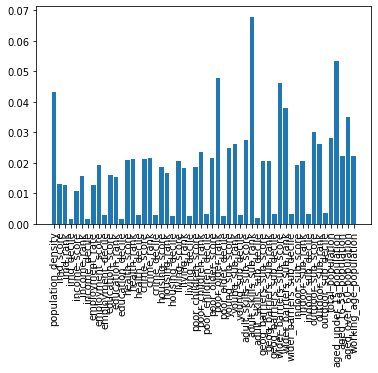

In [115]:
feature_imp(model, x_train)

It looks like the features that have a bigger contributions adult_skills_sub_rank, aged_under_15_population, population_density...

### Let's repeat it at local authority level

In [116]:
agg_cols = {}

#include only scores. Deciles are poorly predictive as shown before (and as expected)
to_include = [x for x in list(data.columns) if x.endswith('_score')]

for key in ['loneills', 'population_density'] + to_include:
    agg_cols[key] = 'mean'

for key in ['aged_under_15_population', 'aged_16-59_population', 'aged_over_60_population', 'total_population']:
    agg_cols[key] = 'sum'

for key in ['district_name']:
    agg_cols[key] = 'first'

la_loneliness= data.groupby(['district_code'], as_index=False).agg(agg_cols)

In [117]:
la_loneliness.head()

,district_code,loneills,population_density,imd_score,income_score,employment_score,education_score,health_score,crime_score,housing_score,...,adult_skills_sub_score,geog_barriers_sub_score,wider_barriers_sub_score,indoor_sub_score,outdoor_sub_score,aged_under_15_population,aged_16-59_population,aged_over_60_population,total_population,district_name
0,E06000001,-0.669530,3257.600098,43.928600,0.329800,3205.300000,41.921600,1.326500,0.130500,12.166700,...,0.443900,-0.400500,-0.896200,-1.086800,-0.094300,3454.0,9828.0,3909.0,17191.0,Hartlepool
1,E06000002,4.412327,4745.083496,52.641333,0.350917,5108.416667,53.863417,1.755833,0.952167,18.014667,...,0.455917,-0.737500,1.144083,-0.318750,0.301083,4185.0,13854.0,3303.0,21342.0,Middlesbrough
2,E06000003,0.524035,3225.000000,34.006636,0.242091,6365.454545,27.375182,1.093455,0.280727,7.179273,...,0.358455,-0.559818,-2.448636,-0.279364,-0.636545,2770.0,9201.0,4496.0,16467.0,Redcar and Cleveland
3,E06000004,-0.020585,3429.307617,37.622692,0.266077,7226.461538,34.585462,1.111538,0.310154,12.811846,...,0.363538,-0.356615,-0.956000,-0.557000,-0.212385,4049.0,12831.0,4521.0,21401.0,Stockton-on-Tees
4,E06000005,1.914055,4022.818115,26.531909,0.190636,11908.363636,22.879727,0.617364,0.403455,7.068091,...,0.309909,-0.743091,-2.758545,-0.401455,-0.192818,2987.0,9719.0,4004.0,16710.0,Darlington


In [118]:
x_train, y_train, x_test, y_test = process_data(la_loneliness)

In [119]:
la_model = RandomForestRegressor()


In [120]:
la_model.fit(x_train, y_train)

RandomForestRegressor()

In [121]:
la_model.score(x_test, y_test)

0.24708836046496108

                     Feature  Importance
17  aged_under_15_population    0.087247
12    adult_skills_sub_score    0.072904
13   geog_barriers_sub_score    0.068427
11           young_sub_score    0.063858
10          poor_older_score    0.061276
16         outdoor_sub_score    0.055380
14  wider_barriers_sub_score    0.054232
6                crime_score    0.050910
7              housing_score    0.050565
0         population_density    0.047960
5               health_score    0.042176
8               living_score    0.041160
15          indoor_sub_score    0.041028
3           employment_score    0.039538
4            education_score    0.038668
9        poor_children_score    0.038495
2               income_score    0.034850
19   aged_over_60_population    0.034391
1                  imd_score    0.030812
20          total_population    0.023331
18     aged_16-59_population    0.022793


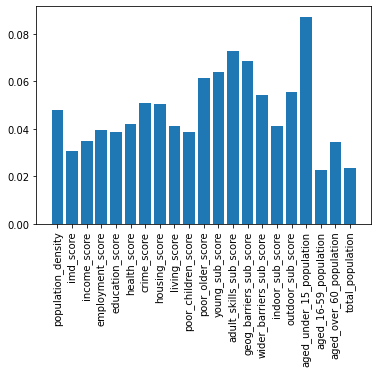

In [122]:
feature_imp(la_model, x_train)

,population_density,imd_score,income_score,employment_score,education_score,health_score,crime_score,housing_score,living_score,poor_children_score,...,young_sub_score,adult_skills_sub_score,geog_barriers_sub_score,wider_barriers_sub_score,indoor_sub_score,outdoor_sub_score,aged_under_15_population,aged_16-59_population,aged_over_60_population,total_population
279,4239.000000,35.685413,0.247853,6504.353027,34.488117,1.268118,0.191059,14.557088,11.010000,0.286471,...,0.354000,0.411853,-0.501412,-0.230882,-0.869559,-0.086971,9075.0,32615.0,12173.0,53863.0
128,4212.823730,12.198824,0.102588,22200.470703,14.778000,-0.666000,-0.176471,16.862293,13.274529,0.131882,...,-0.312588,0.271588,-0.443412,0.726941,-0.179235,-0.390471,5855.0,17710.0,5688.0,29253.0
155,2196.000000,21.150785,0.152786,15136.857422,17.426001,0.520571,-0.298786,17.005928,12.596143,0.154786,...,-0.329500,0.305143,0.053929,-0.964571,-0.170500,-0.354214,3395.0,11506.0,5768.0,20669.0
7,5410.409180,42.982681,0.271727,4987.227051,43.188274,1.360727,0.686182,10.698363,37.903954,0.267864,...,0.418864,0.477182,-0.959909,-0.190273,0.787364,0.470818,9212.0,22149.0,5687.0,37048.0
290,4428.482910,31.767090,0.193876,12963.786133,31.178383,0.654753,0.526652,18.109596,35.174831,0.232067,...,0.333045,0.339337,-0.608438,0.959978,0.571405,0.648697,26937.0,92685.0,28343.0,147965.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,2805.516113,33.284290,0.210065,9119.806641,37.913063,0.794387,0.707355,9.590806,21.769161,0.246774,...,0.409097,0.415806,-0.522355,-1.614581,-0.239290,0.694226,9010.0,28326.0,11429.0,48765.0
39,2980.646973,10.330471,0.083118,24497.234375,10.271000,-1.121941,0.013824,15.314706,15.534588,0.093765,...,-0.403059,0.204412,-0.192176,-0.297118,-0.338588,0.130588,6199.0,18023.0,5919.0,30141.0
253,3958.555664,6.713333,0.065333,26503.445312,3.102111,-1.169667,-0.478000,14.138667,17.543888,0.078444,...,-1.001556,0.138444,-0.331667,-0.106889,-0.299111,0.342556,3362.0,9967.0,3486.0,16815.0
287,5399.677734,38.254765,0.230034,9693.830078,40.189526,0.852983,0.657797,17.511339,41.768272,0.242695,...,0.453864,0.419322,-0.706475,0.999492,0.918373,0.533034,24124.0,61677.0,17376.0,103177.0


Not a significant improvement.


### Let's see if deprivation-related features can predict the single conditions contributing to the loneliness index

In [9]:
data_individual = pd.read_csv('england/with_density.csv')
data_individual['population_density'] = data_individual['population_density'].str.replace(',', '').astype('float32')

data_individual.head()

,lsoa11,population_density,year,loneills,depression_zscore,alzheimers_zscore,hypertension_zscore,insomnia_zscore,addiction_zscore,social anxiety_zscore,...,indoor_sub_rank,indoor_sub_decile,outdoor_sub_score,outdoor_sub_rank,outdoor_sub_decile,total_population,aged_under_15_population,aged_16-59_population,aged_over_60_population,working_age_population
0,E01020636,1886.0,2015,0.651901,0.961753,1.595723,-0.101217,-0.894518,-0.101102,-0.808738,...,32265.0,10.0,-1.482,31684.0,10.0,1704.0,306.0,956.0,442.0,976.50
1,E01020629,3270.0,2015,0.299419,0.644432,-0.334643,0.234711,0.331926,-0.101102,-0.475905,...,25589.0,8.0,-1.215,30432.0,10.0,1488.0,304.0,836.0,348.0,839.25
2,E01020655,242.0,2015,-0.231131,1.042542,0.685927,-0.588718,-0.533124,-0.101102,-0.736656,...,29921.0,10.0,-1.748,32368.0,10.0,2039.0,333.0,1115.0,591.0,1142.50
3,E01020661,2193.0,2015,-1.047568,0.446563,0.490636,-0.577136,-0.801609,-0.094337,-0.511685,...,19737.0,7.0,-0.446,22845.0,7.0,1841.0,316.0,1046.0,479.0,1073.50
4,E01020615,2871.0,2015,-1.014707,0.483654,0.036102,0.262006,-1.006653,-0.100593,-0.689223,...,32597.0,10.0,-0.440,22773.0,7.0,1786.0,352.0,984.0,450.0,981.00


In [19]:
train, test = train_test_split(data_individual, test_size=0.2)
x_train = train.copy()
x_test = test.copy()
for feature in ['lsoa11', 'year', 'lsoa_name', 'district_code', 'district_name', 'loneills']:
    if feature in list(data_individual.columns):
        x_train.drop(feature, axis=1, inplace=True)
        x_test.drop(feature, axis=1, inplace=True)
x_train = x_train.astype('float32').loc[:, ~x_train.columns.str.endswith('_zscore')]
x_test = x_test.astype('float32').loc[:, ~x_test.columns.str.endswith('_zscore')]
y_train = train.loc[:, train.columns.str.endswith('_zscore')]
y_test = test.loc[:, test.columns.str.endswith('_zscore')]

In [20]:
per_condition_model = RandomForestRegressor()

In [21]:
per_condition_model.fit(x_train,y_train)

RandomForestRegressor()

In [22]:

per_condition_model.score(x_test, y_test)

0.07326367269479346

                      Feature  Importance
14                health_rank    0.070636
17                 crime_rank    0.046954
52    aged_over_60_population    0.042224
50   aged_under_15_population    0.039281
0          population_density    0.038640
16                crime_score    0.037721
35      adult_skills_sub_rank    0.034988
41    wider_barriers_sub_rank    0.029357
40   wider_barriers_sub_score    0.029156
49           total_population    0.029122
51      aged_16-59_population    0.027067
32             young_sub_rank    0.025865
13               health_score    0.025671
26         poor_children_rank    0.025033
53     working_age_population    0.024793
31            young_sub_score    0.024263
10            education_score    0.022549
37    geog_barriers_sub_score    0.022084
46          outdoor_sub_score    0.021293
8            employment_score    0.020289
47           outdoor_sub_rank    0.019776
34     adult_skills_sub_score    0.019100
29            poor_older_rank    0

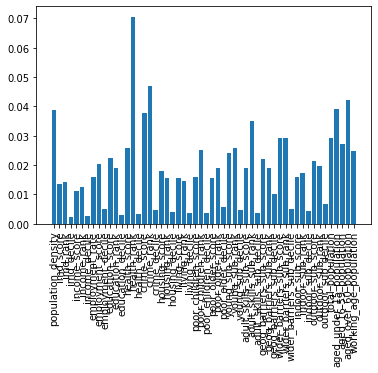

In [23]:
feature_imp(per_condition_model, x_train)

Poor performance again, but this time feature importances make sense: it is expected that health rank, crime rank
and population statistics contribute to the 6 medical conditions.